
## Project Description

Modern deep learning hinges on variants of stochastic gradient descent. Give an overview of some of the algorithms (ADAM,
RMSProp, Adagrad,momentum, etc.) and stepsizing schemes (learning rate decay, cosine annealing, superconvergence, hyper-
gradient learning rate adaptation, etc.) and perform an empirical comparison of their performance on some test problems of
your choice. Obviously, no comparison here can be anywhere close to exhaustive due to the overabundance of deep learning op-
timization papers, so just go through a handful of ideas that you find interesting. If you want to do this with realistic (somewhat
large) networks, you’ll probably need access to some GPUs. This will take a bit more work (but should still be doable!) to do
as a project if you don’t have any previous experience in deep learning.




## Notes:
- Test problems:
  - [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html)
    - image classification
  - [minGPT](https://github.com/karpathy/minGPT?tab=readme-ov-file)
    - Text Generation (but trained by filling in missing words)
  - [California Housing](https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html)
    - Regression (predict housing cost)
  - Simple 1D optimization to visualize things
    - Rosenbrock function




## Text Generation


### Imports

In [1]:
# Reload external files when running cells
%load_ext autoreload
%autoreload 2

# Imports
import torch
import numpy as np
import pathlib
import os
import sys
import matplotlib.pyplot as plt

# Add custom package to import path and import it
file_dir = pathlib.Path().resolve()
pkg_dir = os.path.join(file_dir, "submodules")
print(pkg_dir)
sys.path.insert(0, pkg_dir)
sys.path.insert(0, os.path.join(pkg_dir, "minGPT"))
sys.path.insert(0, os.path.join(pkg_dir, "amath515_pkg"))
from amath515_pkg.src import *

# Load minGTP
from mingpt.model import GPT
from mingpt.trainer import Trainer
from mingpt.utils import CharDataset, CfgNode as CN

# Load config file
pkg_config = helpers.get_config()

# Set seeds
np.random.seed(pkg_config['mingpt_np_seed'])
torch.manual_seed(pkg_config['mingpt_torch_seed'])

# Print matplotlibe plots inline
%matplotlib inline

# Make sure Torch is installed and see if a GPU is available
print("GPU Available?",torch.cuda.is_available())
device = "cpu"
if torch.cuda.is_available():
    device = "cuda"


/home/alexey/School/Classes/AMATH 515/AMATH515_Project/submodules
GPU Available? True


### Load Tiny Shakespeare Dataset

In [2]:

# To download tiny-shakespeare, go to https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt and put it in the "Datasets" folder
mingpt_config = helpers.get_minGPT_config()
mingpt_config.data.block_size = pkg_config['mingpt_block_size']
with open(os.path.join(file_dir, 'Datasets', 'tiny-shakespeare.txt'), 'r') as file:
    tiny_shakespeare = file.read()
train_dataset = CharDataset(mingpt_config.data, tiny_shakespeare)


data has 1115394 characters, 65 unique.


### Configure model and trainer

In [3]:

# construct the model
mingpt_config.model.vocab_size = train_dataset.get_vocab_size()
mingpt_config.model.block_size = train_dataset.get_block_size()
model = GPT(mingpt_config.model)

# prepare for training otherwise
# construct the trainer object
mingpt_config.trainer.max_iters = pkg_config['mingpt_iters']
mingpt_config.trainer.batch_size = pkg_config['mingpt_batch_size']
mingpt_config.trainer.optimizer_str = pkg_config['mingpt_SGD_method']
mingpt_config.trainer.scheduler_str = pkg_config['mingpt_Scheduler']
trainer = Trainer(mingpt_config.trainer, model, train_dataset)

# construct callback function
callback = lambda x: training.min_gpt_batch_end_callback(model, mingpt_config, train_dataset, x)
trainer.set_callback('on_batch_end', callback)



number of parameters: 2.71M
running on device cuda



### GPT Training


In [4]:

# run the optimization
trainer.run()


batch:
torch.Size([63, 127]) torch.Size([63, 127])
[tensor(54), tensor(53), tensor(47), tensor(57), tensor(53), tensor(52), tensor(53), tensor(59), tensor(57), tensor(1), tensor(57), tensor(50), tensor(39), tensor(60), tensor(43), tensor(6), tensor(1), tensor(45), tensor(53), tensor(58), tensor(1), tensor(40), tensor(63), tensor(1), tensor(58), tensor(46), tensor(43), tensor(1), tensor(42), tensor(43), tensor(60), tensor(47), tensor(50), tensor(1), tensor(46), tensor(47), tensor(51), tensor(57), tensor(43), tensor(50), tensor(44), tensor(0), tensor(33), tensor(54), tensor(53), tensor(52), tensor(1), tensor(58), tensor(46), tensor(63), tensor(1), tensor(61), tensor(47), tensor(41), tensor(49), tensor(43), tensor(42), tensor(1), tensor(42), tensor(39), tensor(51), tensor(6), tensor(1), tensor(41), tensor(53), tensor(51), tensor(43), tensor(1), tensor(44), tensor(53), tensor(56), tensor(58), tensor(46), tensor(2), tensor(0), tensor(0), tensor(15), tensor(13), tensor(24), tensor(21), tenso

KeyboardInterrupt: 

### Save Data

In [ ]:

save_dir = os.path.join(file_dir,\
                        "Saved_Data")
save_fn = f"minGPT_{pkg_config['mingpt_SGD_method']}_{pkg_config['mingpt_Scheduler']}.torch"
save_abs = os.path.join(save_dir, save_fn)
os.makedirs(save_dir, mode=0o777, exist_ok=True)
torch.save({
        "losses": trainer.losses,
        "lrs": trainer.lrs,
        "config": pkg_config
    }, save_abs)
print(f"Saved data to \"{save_abs}\"")


Saved data to "/home/alexey/School/Classes/AMATH 515/AMATH515_Project/Saved_Data/minGPT_RMSprop_CosineAnnealingLR.torch"


### Create and Save Plots

Saved plot to "/home/alexey/School/Classes/AMATH 515/AMATH515_Project/Plots/minGPT/minGPT_RMSprop_CosineAnnealingLR_losses.pdf"


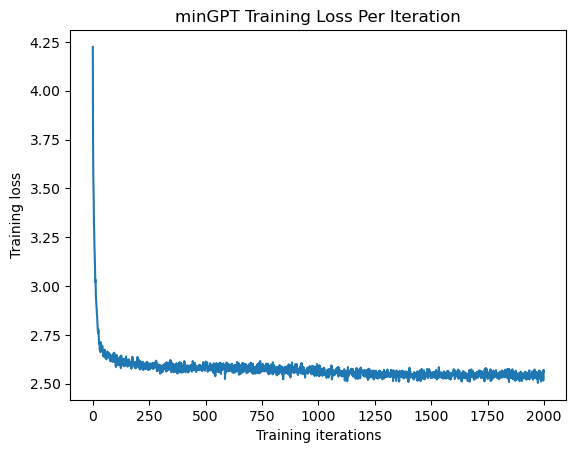

Saved plot to "/home/alexey/School/Classes/AMATH 515/AMATH515_Project/Plots/minGPT/minGPT_RMSprop_CosineAnnealingLR_lrs.pdf"


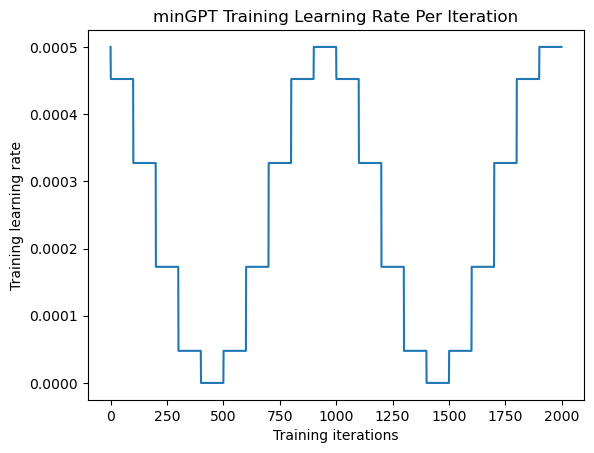

In [ ]:

plot_dir = os.path.join(file_dir, "Plots", "minGPT")
os.makedirs(plot_dir, mode=0o777, exist_ok=True)

# Plot losses
plt.plot(trainer.losses)
plt.ylabel("Training loss")
plt.xlabel("Training iterations")
plt.title("minGPT Training Loss Per Iteration")

# Save losses
plot_fn = f"minGPT_{pkg_config['mingpt_SGD_method']}_{pkg_config['mingpt_Scheduler']}_losses.pdf"
plot_abs = os.path.join(plot_dir, plot_fn)
plt.savefig(plot_abs)
print(f"Saved plot to \"{plot_abs}\"")

plt.show()

# Plot learning rates
plt.plot(trainer.lrs)
plt.ylabel("Training learning rate")
plt.xlabel("Training iterations")
plt.title("minGPT Training Learning Rate Per Iteration")

# Save lrs
plot_fn = f"minGPT_{pkg_config['mingpt_SGD_method']}_{pkg_config['mingpt_Scheduler']}_lrs.pdf"
plot_abs = os.path.join(plot_dir, plot_fn)
plt.savefig(plot_abs)
print(f"Saved plot to \"{plot_abs}\"")

plt.show()
